In [2]:
import matplotlib
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pandas as pd

In [3]:
from skimage import exposure, io, img_as_float
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.feature_extraction import image
from PIL import Image, ImageEnhance

In [4]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from skimage.morphology import label
from skimage.measure import regionprops
from skimage import data, util

In [5]:
import matplotlib.patches as mpatches
from random import random

In [6]:
from scipy import ndimage
from scipy.ndimage import find_objects

In [7]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [8]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")
grayscale = rgb2gray(img)

Estimated Gaussian noise standard deviation = 0.1203845049175647


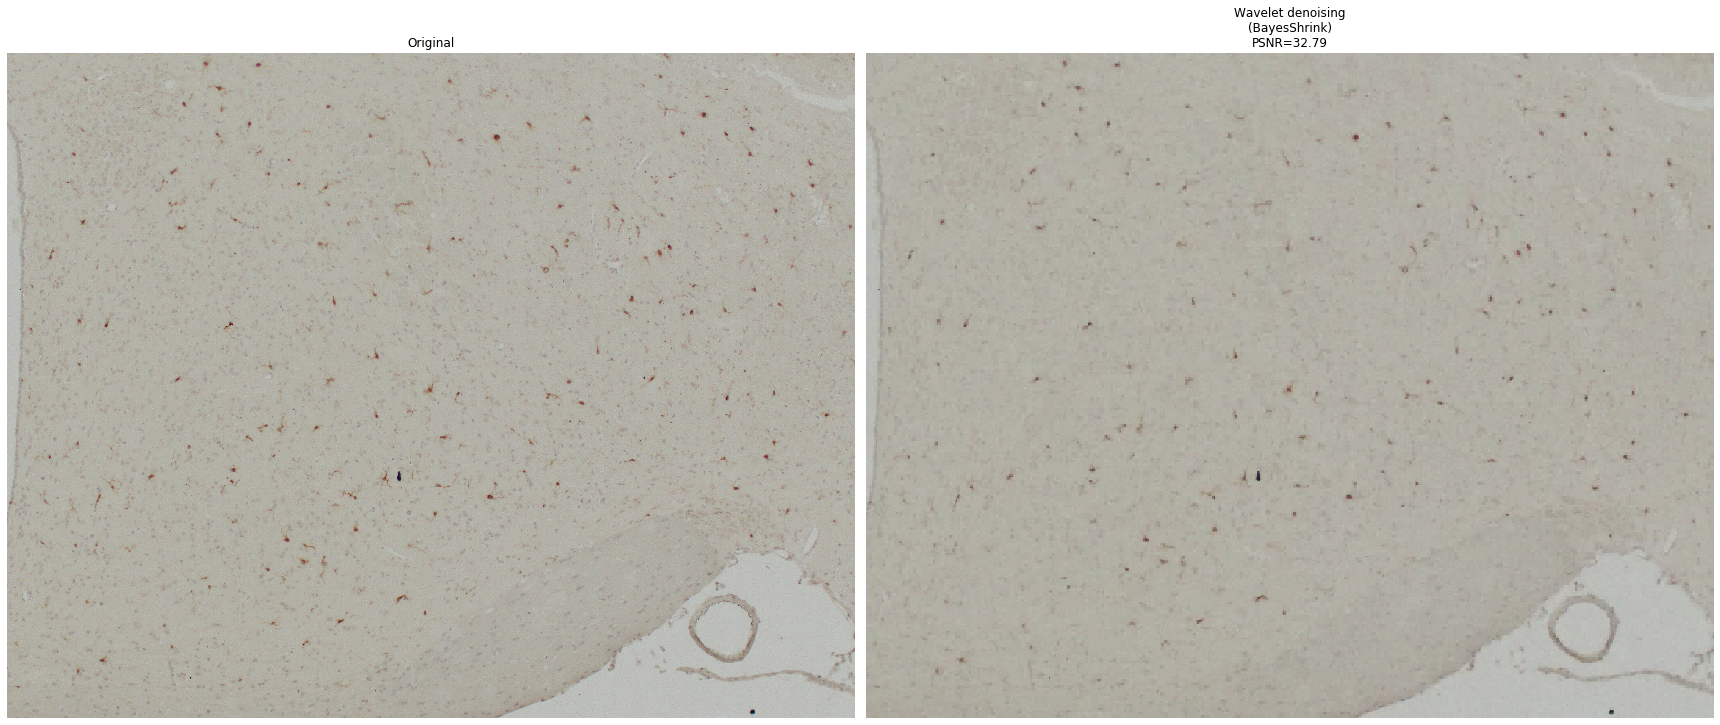

In [9]:
original = img_as_float(img)

sigma = 0.12
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

# Compute PSNR as an indication of image quality
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)

ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title('Original')
fig.tight_layout()

plt.show()

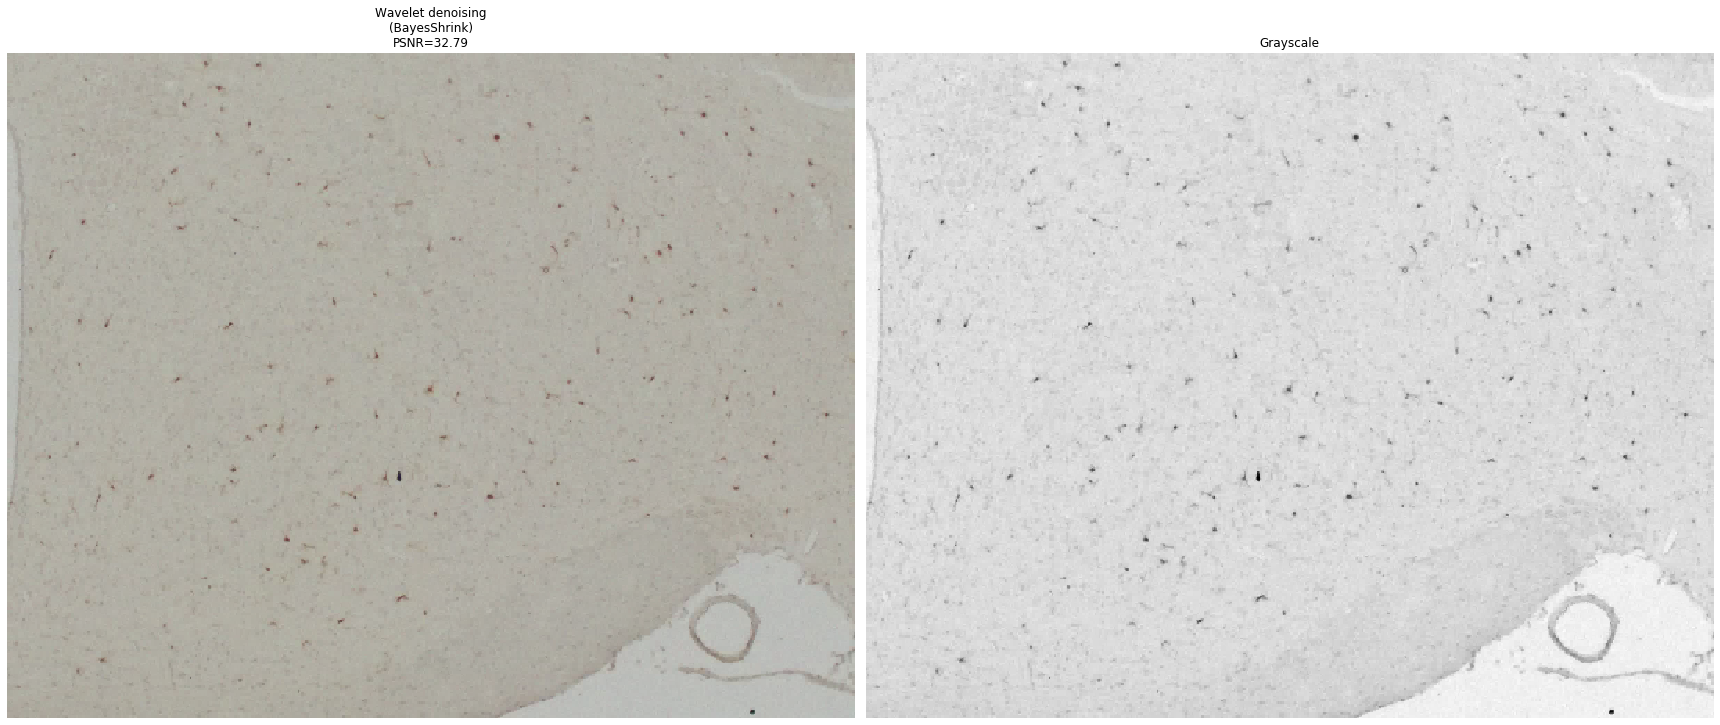

In [10]:
grayscale_bayes = rgb2gray(im_bayes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(im_bayes)
ax[0].axis('off')
ax[0].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[1].imshow(grayscale_bayes)
ax[1].axis('off')
ax[1].set_title('Grayscale')
fig.tight_layout()

plt.show()

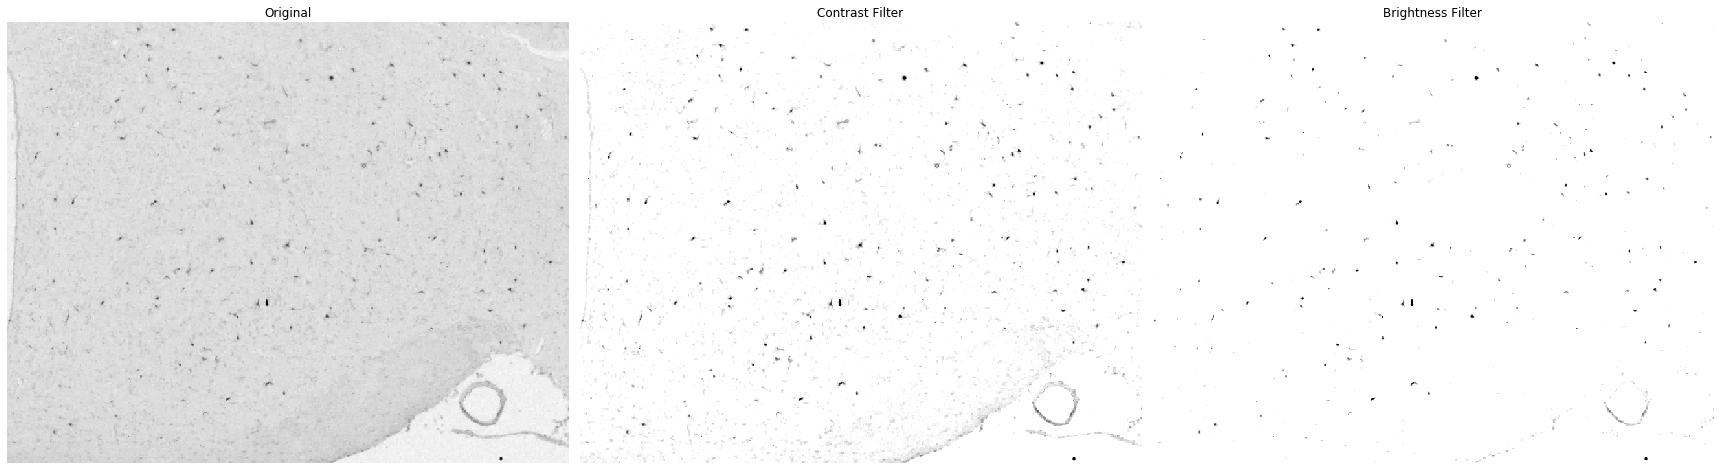

In [11]:
gscale = (grayscale_bayes * 255).astype(np.uint8)
img = Image.fromarray(gscale, mode = 'L')

brightener = ImageEnhance.Brightness(img)
bright_bayes_pil = brightener.enhance(1.5)

contrast = ImageEnhance.Contrast(bright_bayes_pil)
contrast_bayes = contrast.enhance(2)

brightener = ImageEnhance.Brightness(contrast_bayes)
bright_bayes_pil = brightener.enhance(1.2)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(
    'Original'.format(psnr_bayes))
ax[2].imshow(bright_bayes_pil)
ax[2].axis('off')
ax[2].set_title('Brightness Filter')
ax[1].imshow(contrast_bayes)
ax[1].axis('off')
ax[1].set_title('Contrast Filter')
fig.tight_layout()

plt.show()

In [12]:
bright_bayes = np.array(bright_bayes_pil)

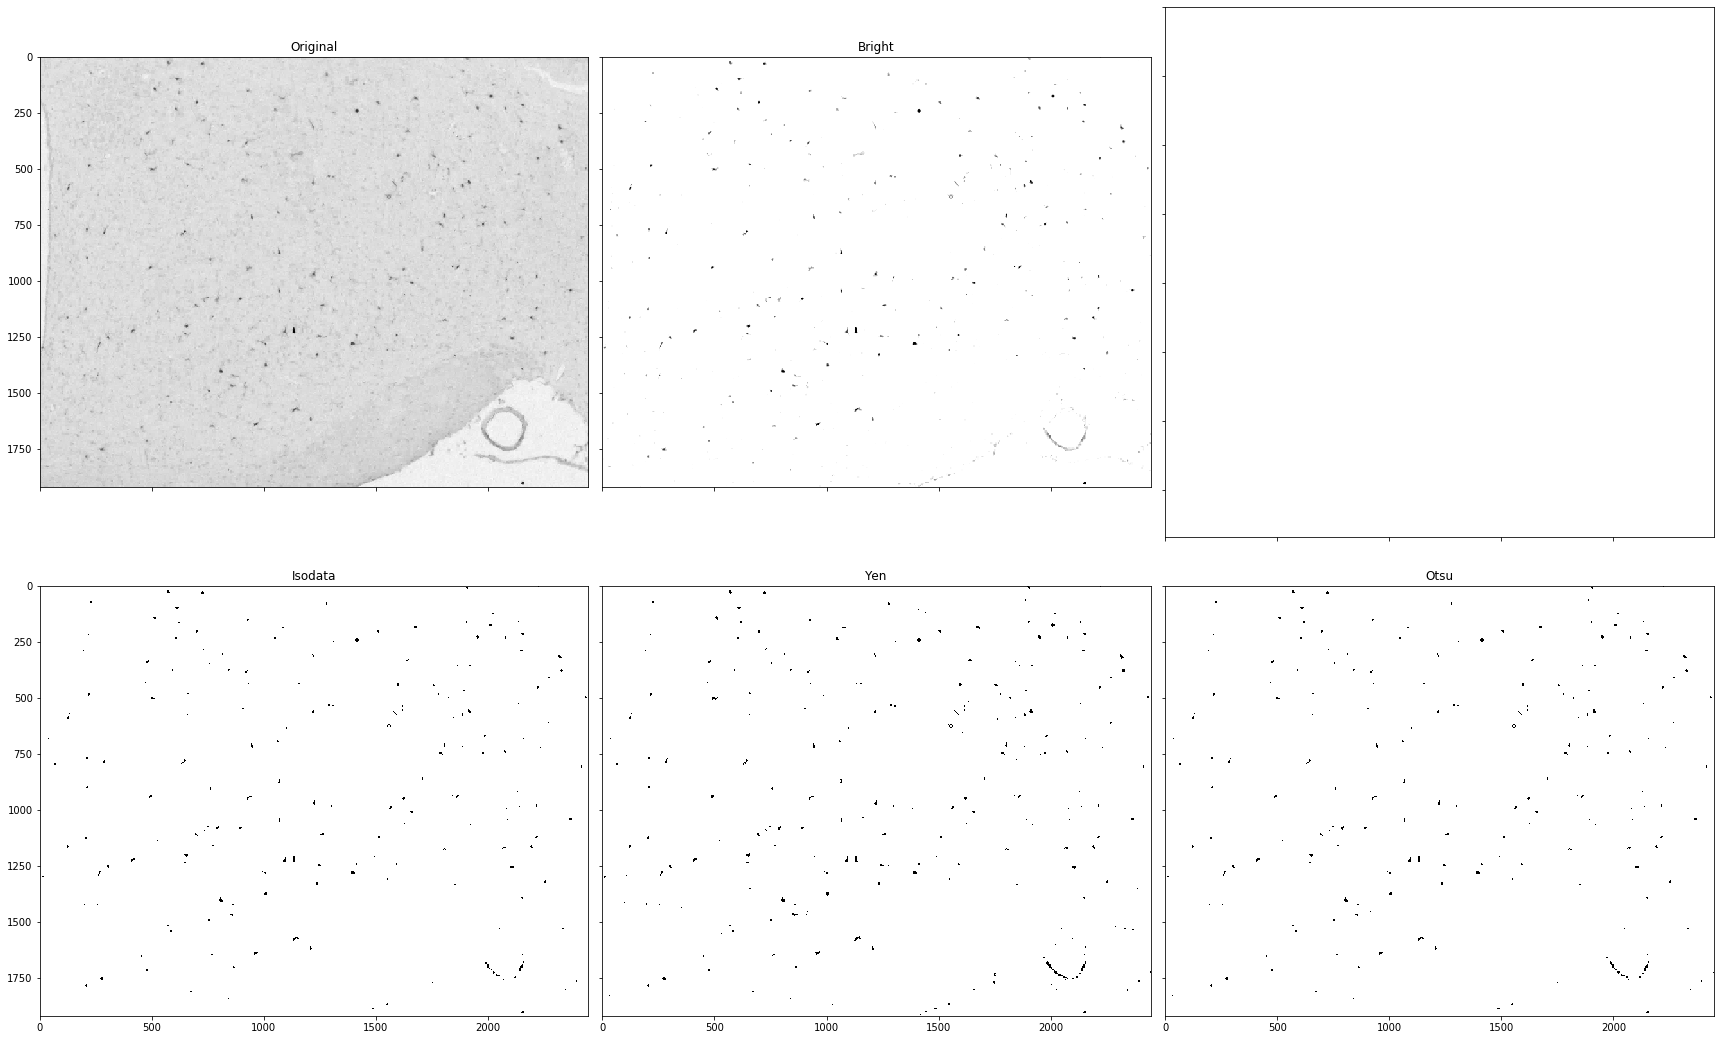

In [13]:
from skimage.filters import threshold_isodata, threshold_yen, threshold_otsu
thresh_iso = threshold_isodata(bright_bayes)
isodata = bright_bayes > thresh_iso

thresh_yen = threshold_yen(bright_bayes)
yen = bright_bayes > thresh_yen

thresh_otsu = threshold_otsu(bright_bayes)
otsu = bright_bayes > thresh_otsu

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(grayscale_bayes)
ax[0, 0].set_title(
    'Original'.format(psnr_bayes))
ax[0, 1].imshow(bright_bayes)
ax[0, 1].set_title(
    'Bright'.format(psnr_bayes))
ax[1, 0].imshow(isodata)
ax[1, 0].set_title(
    'Isodata'.format(psnr_bayes))
ax[1, 1].imshow(yen)
ax[1, 1].set_title(
    'Yen'.format(psnr_bayes))
ax[1,2].imshow(otsu)
ax[1,2].set_title('Otsu')
fig.tight_layout()

plt.show()

In [14]:
#define new colormap
colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

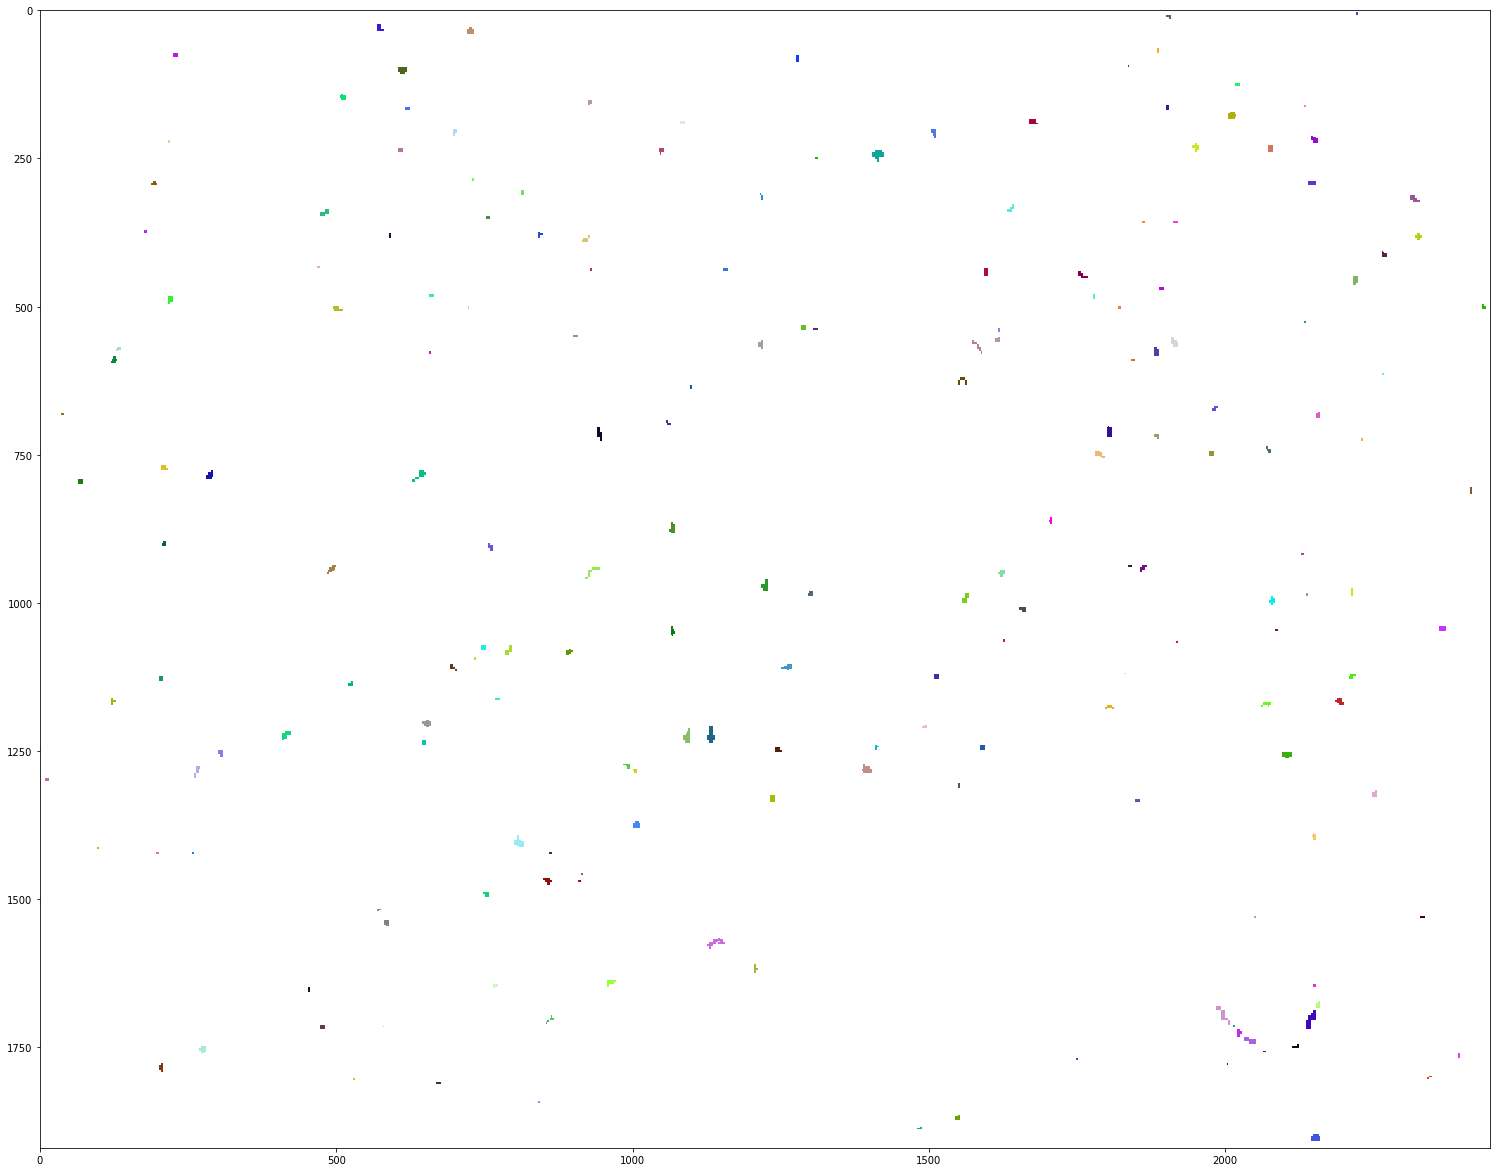

In [15]:
# label image regions
label_image = label(isodata,connectivity=2, background=1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(26, 26))
ax.imshow(label_image, cmap = new_map)

plt.show()

In [16]:
patches = ndimage.find_objects(label_image)
len(patches)

195

In [17]:
patches_sample = [patches[0], patches[1], patches[2]]
patches_sample

[(slice(4, 8, None), slice(2220, 2224, None)),
 (slice(8, 16, None), slice(1900, 1908, None)),
 (slice(24, 36, None), slice(568, 580, None))]

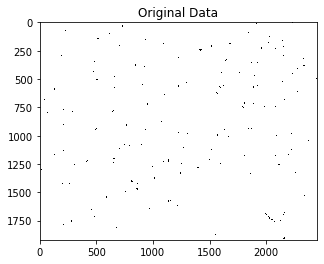

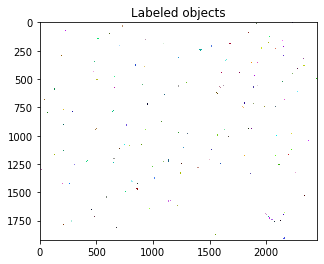

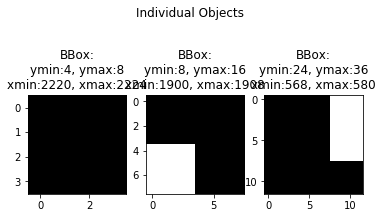

In [18]:
fig, ax = plt.subplots()
ax.imshow(isodata)
ax.set_title('Original Data')

fig, ax = plt.subplots()
ax.imshow(label_image, cmap=new_map)
ax.set_title('Labeled objects')

fig, axes = plt.subplots(ncols=3)
for ax, sli in zip(axes.flat, patches_sample):
    ax.imshow(label_image[sli], cmap = 'gray_r', vmin = 0)
    tpl = 'BBox:\nymin:{0.start}, ymax:{0.stop}\nxmin:{1.start}, xmax:{1.stop}'
    ax.set_title(tpl.format(*sli))
fig.suptitle('Individual Objects')

plt.show()

In [19]:
df = pd.DataFrame(columns=['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent'])

In [20]:
regions = regionprops(label_image)

for region in regions:
    region_dict = {'solidity': region.solidity,
                   'orientation': region.orientation,
                   'diameter': region.equivalent_diameter,
                   'area': region.area,
                   'eccentricity': region.eccentricity,
                   'convex area': region.convex_area,
                   'major axis length': region.major_axis_length,
                   'minor axis length': region.minor_axis_length,
                   'extent': region.extent}
    df=df.append(region_dict, ignore_index=True)

In [21]:
df

,solidity,orientation,diameter,area,eccentricity,convex area,major axis length,minor axis length,extent
0,1.000000,0.785398,4.513517,16.0,0.000000,16.0,4.472136,4.472136,1.000000
1,0.888889,0.785398,7.817640,48.0,0.734904,54.0,10.263203,6.960204,0.750000
2,0.875000,0.531849,11.941643,112.0,0.691008,128.0,15.009984,10.849921,0.777778
3,0.903226,-1.570796,11.941643,112.0,0.354507,124.0,12.895182,12.057684,0.777778
4,1.000000,0.000000,6.383076,32.0,0.872872,32.0,9.165151,4.472136,1.000000
...,...,...,...,...,...,...,...,...,...
190,1.000000,1.570796,6.383076,32.0,0.872872,32.0,9.165151,4.472136,1.000000
191,1.000000,0.785398,4.513517,16.0,0.000000,16.0,4.472136,4.472136,1.000000
192,0.933333,-0.950946,8.444016,56.0,0.594207,60.0,9.689157,7.793105,0.875000
193,0.857143,-1.345070,5.527906,24.0,0.901892,28.0,8.952926,3.867328,0.750000


0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


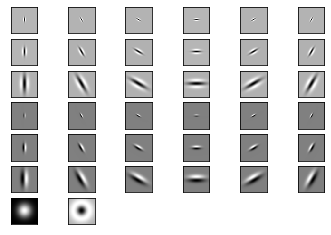

In [22]:
#https://gist.github.com/amueller/3129692
##########################################################################
# Maximum Response filterbank from
# http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
# based on several edge and bar filters.
# Adapted to Python by Andreas Mueller amueller@ais.uni-bonn.de
# Share and enjoy
#

import cv2
import pickle

from itertools import product, chain

def makeRFSfilters(radius=28, sigmas=[1, 2, 4], n_orientations=6):
    """ Generates filters for RFS filterbank.
    Parameters
    ----------
    radius : int, default 28
        radius of all filters. Size will be 2 * radius + 1
    sigmas : list of floats, default [1, 2, 4]
        define scales on which the filters will be computed
    n_orientations : int
        number of fractions the half-angle will be divided in
    Returns
    -------
    edge : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains edge filters on different scales and orientations
    bar : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains bar filters on different scales and orientations
    rot : ndarray (2, 2*radius+1, 2*radius+1)
        contains two rotation invariant filters, Gaussian and Laplacian of
        Gaussian
    """
    def make_gaussian_filter(x, sigma, order=0):
        if order > 2:
            raise ValueError("Only orders up to 2 are supported")
        # compute unnormalized Gaussian response
        response = np.exp(-x ** 2 / (2. * sigma ** 2))
        if order == 1:
            response = -response * x
        elif order == 2:
            response = response * (x ** 2 - sigma ** 2)
        # normalize
        response /= np.abs(response).sum()
        return response

    def makefilter(scale, phasey, pts, sup):
        gx = make_gaussian_filter(pts[0, :], sigma=3 * scale)
        gy = make_gaussian_filter(pts[1, :], sigma=scale, order=phasey)
        temp = gx*gy
        temp = np.reshape(temp,(gx.shape[0],1))
        #f = (gx * gy).reshape(sup, sup)
        f = np.reshape(temp,(int(sup), int(sup)))
        # normalize
        f /= np.abs(f).sum()
        return f

    support = 2 * radius + 1
    x, y = np.mgrid[-radius:radius + 1, radius:-radius - 1:-1]
    orgpts = np.vstack([x.ravel(), y.ravel()])

    rot, edge, bar = [], [], []
    for sigma in sigmas:
        for orient in range(n_orientations):
            # Not 2pi as filters have symmetry
            angle = np.pi * orient / n_orientations
            c, s = np.cos(angle), np.sin(angle)
            rotpts = np.dot(np.array([[c, -s], [s, c]]), orgpts)
            edge.append(makefilter(sigma, 1, rotpts, support))
            bar.append(makefilter(sigma, 2, rotpts, support))

    print (len(rot), len(bar))
    length = np.sqrt(x ** 2 + y ** 2)
    rot.append(make_gaussian_filter(length, sigma=10))
    rot.append(make_gaussian_filter(length, sigma=10, order=2))

    # reshape rot and edge
    edge = np.asarray(edge)
    edge = edge.reshape(len(sigmas), n_orientations, int(support), int(support))
    bar = np.asarray(bar).reshape(edge.shape)
    rot = np.asarray(rot)[:, np.newaxis, :, :]
    print (edge.shape, bar.shape, rot.shape)
    return edge, bar, rot


def apply_filterbank(img, filterbank):
    from scipy.ndimage import convolve
    result = []

    for battery in filterbank:
        for filt in battery:
            response = [convolve(img, filt)]
        max_response = np.max(response, axis=0)
        result.append(max_response)
        print("battery finished")

    return result


if __name__ == "__main__":

    sigmas = [1, 2, 4]
    n_sigmas = len(sigmas)
    n_orientations = 6

    edge, bar, rot = makeRFSfilters(sigmas=sigmas,
            n_orientations=n_orientations)

    n = n_sigmas * n_orientations

    # plot filters
    # 2 is for bar / edge, + 1 for rot
    fig, ax = plt.subplots(n_sigmas * 2 + 1, n_orientations)
    for k, filters in enumerate([bar, edge]):
        for i, j in product(range(n_sigmas), range(n_orientations)):
            row = i + k * n_sigmas
            ax[row, j].imshow(filters[i, j, :, :], cmap=plt.cm.gray)
            ax[row, j].set_xticks(())
            ax[row, j].set_yticks(())
    ax[-1, 0].imshow(rot[0, 0], cmap=plt.cm.gray)
    ax[-1, 0].set_xticks(())
    ax[-1, 0].set_yticks(())
    ax[-1, 1].imshow(rot[1, 0], cmap=plt.cm.gray)
    ax[-1, 1].set_xticks(())
    ax[-1, 1].set_yticks(())
    for i in range(2, n_orientations):
        ax[-1, i].set_visible(False)

    plt.show()

In [22]:
label_image_extra = label_image[:,:,None]

In [23]:
filterbank = makeRFSfilters()
apply_filterbank(label_image_extra, filterbank)

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)
filt
filt
filt
battery finished
filt
filt
filt
battery finished
filt
filt
battery finished


[array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]]), array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
      

In [24]:
#extract MR8 texture features: 36 bar and edge filters, a Gaussian filter, and a Laplacian of Gaussian filter. The eight highest responses are extracted to maintain rotation invariance. 

In [25]:
#extract HoG feature

TypeError: Image data of dtype object cannot be converted to float

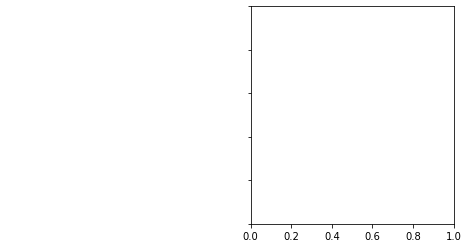

In [25]:
image = patches[2]
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [26]:
feature_names = ['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent', 'hog']
#include texture features
labels = [0, 1]

In [27]:
#features are numeric values, the vector created by combining/concatenating these values is the X data
#this vector is created for each patch, and paired with a label to create the dataset

In [28]:
clf = svm.LinearSVC()

#clf.fit(X_train, y_train)

#Predict the response for test dataset
#y_pred = clf.predict(X_test)

In [29]:
#this classifier is going to give a prediction for each patch, 
#so to get the total number of positive cells in an image we will need to sum the label values of the patches